In [91]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib import pyplot
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from numpy.core.multiarray import ndarray
import math
import numpy as np
import matplotlib as mpl
import matplotlib.backends.backend_pdf
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.odr import Model
from xlrd import open_workbook
from scipy.optimize import curve_fit
from pandas import read_csv
import statistics
import scipy as scipy
from scipy import optimize
import matplotlib.ticker as ticker
#import lmfit
import scipy.constants as scpc
import random
#######################################################
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 75
mpl.rcParams['font.family'] = 'Sans Serif'
mpl.rcParams['axes.labelsize'] = 36
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.direction'] = "in"

In [93]:
datafiles=[
     "YMnSn_240_290K_350_perp", 
    "YMnSn_240_290K_300_perp",
    "YMnSn_240_290K_250",
    "YMnSn_240_290K_200",
     "YMnSn_240_290K_150",
     "YMnSn_240_290K_100",
    "YMnSn_240_290K_050",
    "YMnSn_240_290K_000",
    "YMnSn_240_290K_950",
    "YMnSn_240_290K_900",
     "YMnSn_240_290K_850",
    #"YMnSn_240_290K_800",
    #"YMnSn_240_290K_750_nextDay",
     #"YMnSn_240_290K_700_nextDay",
    #"YMnSn_240_290K_650_nextDay",
    #"YMnSn_240_290K_600_nextDay",
    #"YMnSn_240_290K_550_nextDay",
    #"YMnSn_240_290K_500_nextDay",
     #"YMnSn_240_290K_450_nextDay",
    #"YMnSn_240_290K_400_nextDayFiltered_rephased",
     #"YMnSn_240_290K_350_nextDay",
    #"YMnSn_240_290K_250_p1",
    #"YMnSn_240_290K_150_p1",
    #"YMnSn_240_290K_050_p1",
     #"YMnSn_240_290K_900_p1",
    #"YMnSn_240_290K_875_p1",
     #"YMnSn_240_290K_850_p1",
     #"YMnSn_240_290K_825_p1",
    #"YMnSn_240_290K_800_p1",
    #"YMnSn_240_290K_773_p1",
     #"YMnSn_240_290K_750_p1",
    #"YMnSn_240_290K_700_p1"
          ]

### Dictionaries and Lists ###
dict_data={}
gfactors=[]
linewidths=[]
temps=[]

X1_angles=[60,30,270,310,50,295,200,45,250,190,190]
rotations=[0,9,18,27,36,45,54,63,72,81,90]
rotations_radians=(np.array(rotations)*3.14159/180)


### Fit Functions ###

def dLorentzian(x, amp, cen, wid,disp):
        df = ((- amp * wid/(2*math.pi)* (x - cen))/(((x - cen)**2 + (wid/2)**2)**2))+disp
        return df
    
    ####### Beginning Loop through all datafiles, commands will be repeated for each upsweep and downsweep file ########
for i in range(len(datafiles)):
    
######### Parsing filename for temperature ##############################
    temp=datafiles[i][10:43]
    while temp[-1]!="K":
        temp=temp[0:len(temp)-1]
    temp=temp.replace("p", "." )
    temp2=float(temp[0:-1])
  

    
######## Parsing for header length ######################################
    file=open(datafiles[i]+".dat")
    data=file.readlines()
    for n, line in enumerate(data):
        array=line.split('\s+')
        if array[0][0:6]==">BEGIN":
            header_index=n
            #print(header_index)
            break
    file.close()
    
    ### Sorting ###
    data_u=np.array(pd.read_csv(datafiles[i]+".dat", sep='\s+',header=header_index))

    phi_1=X1_angles[i]
    
    B=data_u[:,0]
    B_field=0.99775*B + 0.00013*(B**2)
    X1=data_u[:,1]
    X2=data_u[:,2]
    X1_corrected = X1*np.cos(np.radians(phi_1))+X2*np.sin(np.radians(phi_1))
    
        ### Guess Values for Lorentzian ### 

    y0_val_max = (max(X1_corrected))
    y0_val_min = (min(X1_corrected))
    
    y0_index_max = np.where(X1_corrected == y0_val_max)[0]
    y0_index_max_refined = random.choice(y0_index_max)
    
    y0_index_min = np.where(X1_corrected == y0_val_min)[0]
    y0_index_min_refined = random.choice(y0_index_min)
    
    xmax = (B_field[y0_index_max_refined])
    xmin = (B_field[y0_index_min_refined])
    
    y0_val = (y0_val_max+y0_val_min)
    H0_val = ((xmax+xmin)/2)
    wid_val = abs(xmax-xmin)
    amp_val =2*math.pi*3**(1/2)*wid_val**2/9*y0_val_max
    disp_val = X1_corrected[0]
    
    
    ### Fitting Parameters ###

    dLparameters,_ = curve_fit(dLorentzian, B_field, X1_corrected, [amp_val, H0_val,wid_val,disp_val])
    
    x_line = np.arange(min(B_field), max(B_field), 0.000181)
    dy_line = dLorentzian(x_line, dLparameters[0], dLparameters[1], dLparameters[2],dLparameters[3])
    
    
    ### Extracting Fit Parameters ###

    g_factor = (6.62607 * 10**(-34) * 2.4 * 10**11)/(scpc.value('Bohr magneton') * dLparameters[1])
    linewidth = dLparameters[2]

### Loading Data into Dictionarires ###
    dict_data[datafiles[i]]=[B_field, #0
                             X1, #1
                             X2, #2
                             temp, #3
                             X1_corrected, #4
                             x_line, #5
                             dy_line, #6
                             g_factor, #7
                             linewidth, #8
                             phi_1, #9
                             dLparameters[1], #10
                             disp_val, #11
                             X1_corrected[0], #12
                            ]
          


    
    gfactors.append(g_factor)
    linewidths.append(linewidth)
    temps.append(temp2)

print(gfactors)
print(linewidths)
print("Length of angles:", len(rotations_radians))
print("Length of linewidths:", len(linewidths))

[1.7611635839827562, 1.7731361310038714, 1.811313947296026, 1.8566889628068302, 1.937646596912769, 1.993697101550954, 2.027704427663585, 2.1336517257396026, 2.076746456255769, 2.2104591561843967, 2.2240599435561874, 1.9945019850935997, 1.9936587757157653, 2.1333878658841083, 2.0651010118141877, 2.0075012825873317, 1.9665928936567159, 1.862950300844338, 2.006424856591908, 2.011530900193687, 2.0096138319487267]
[0.15148265736441163, 0.11196776068347883, 0.08025419152477217, 0.1721742953134772, 0.09506309592631959, 0.4774076184813006, 0.3000099981728595, 0.11369061026958036, 0.6134040899217106, 0.1291214259733397, 0.1712282908395799, 0.05800540605520429, 0.05771660581710069, 0.11112107963817741, 0.11895397883498245, 0.10716200347507787, 0.27829790988143327, 0.13860877734370355, 0.045902250441261325, 0.05020990126003236, 0.05780085549552095]
Length of angles: 21
Length of linewidths: 21


C:\Users\lovia\AppData\Local\Temp\ipykernel_47876\1724547309.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1,ax=plt.subplots()


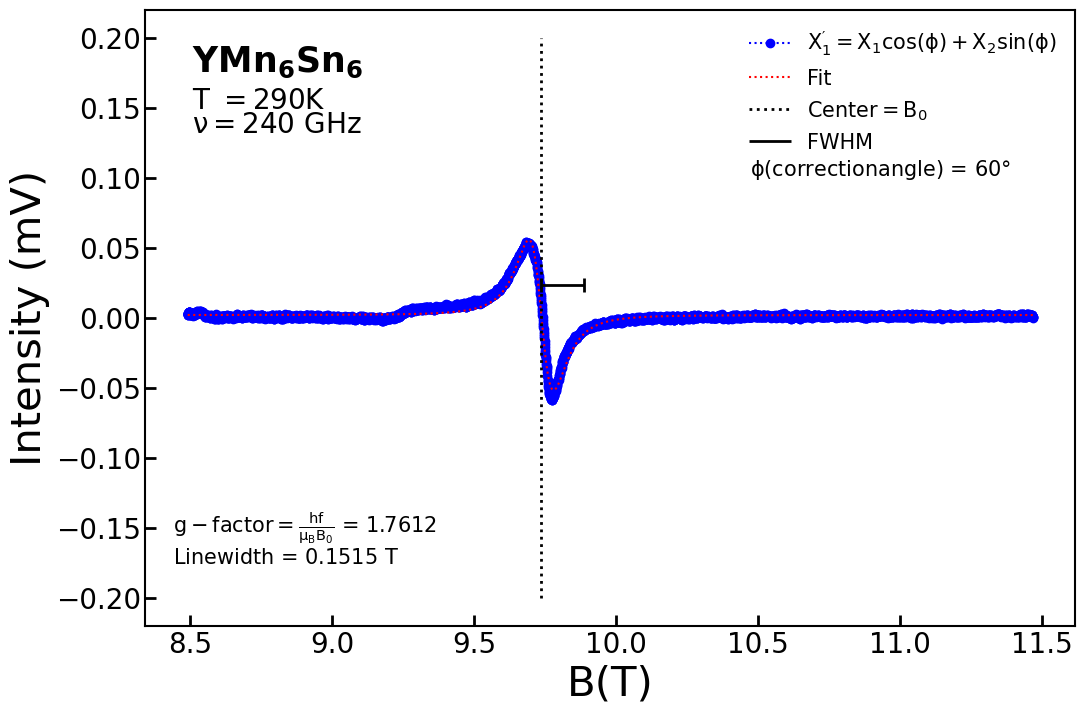

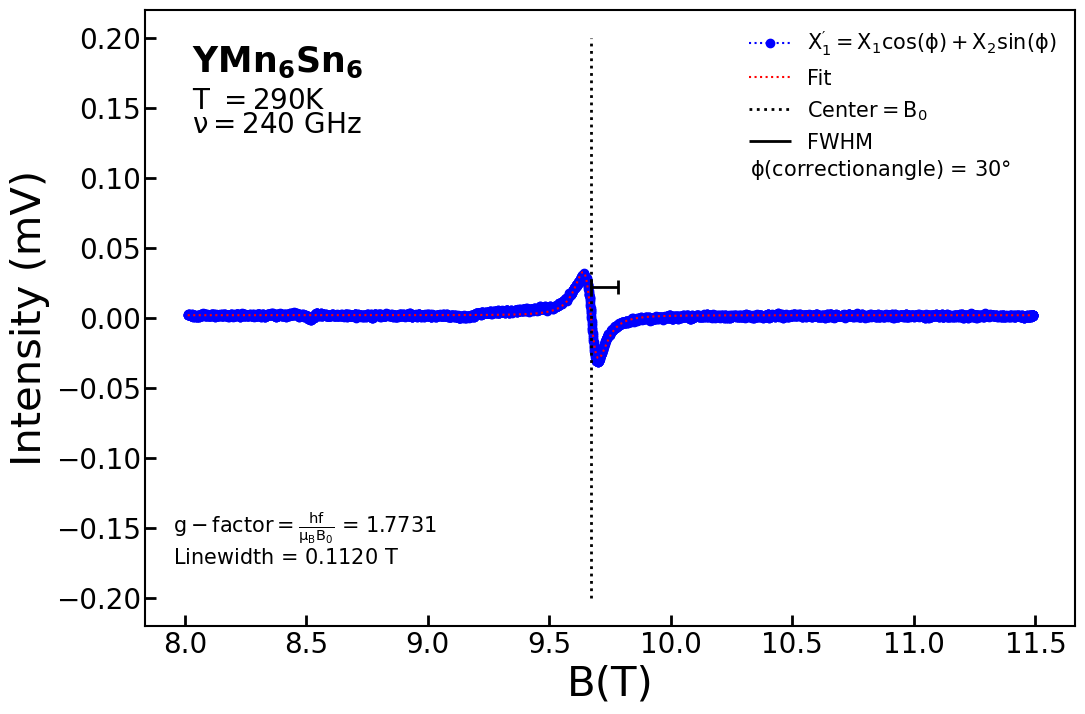

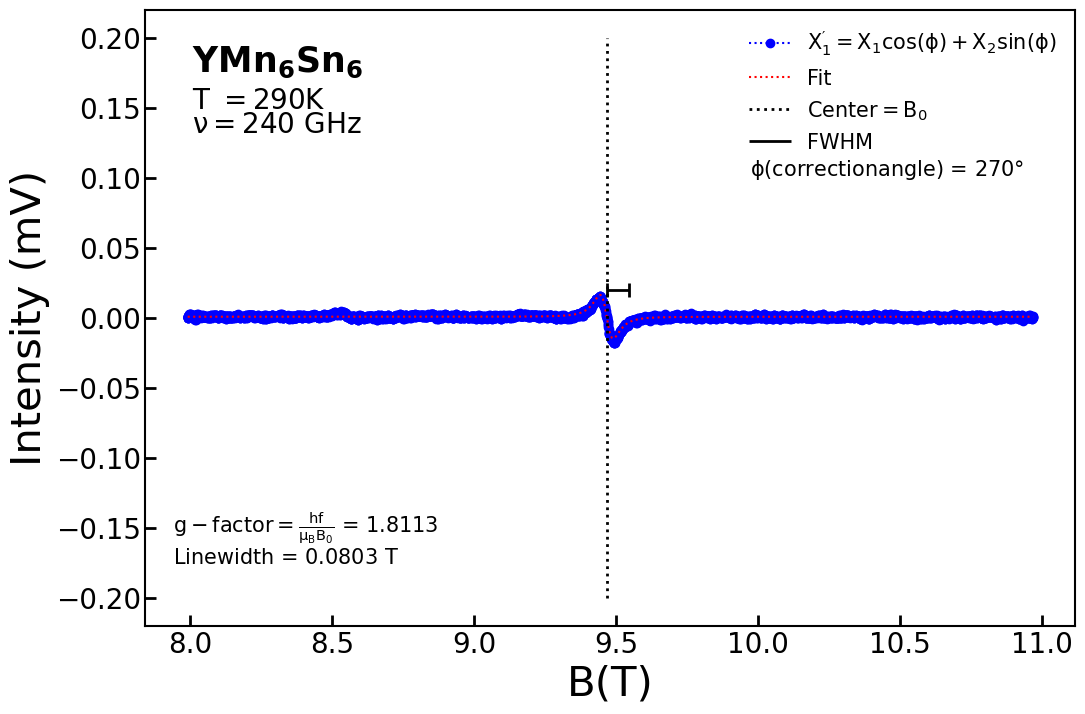

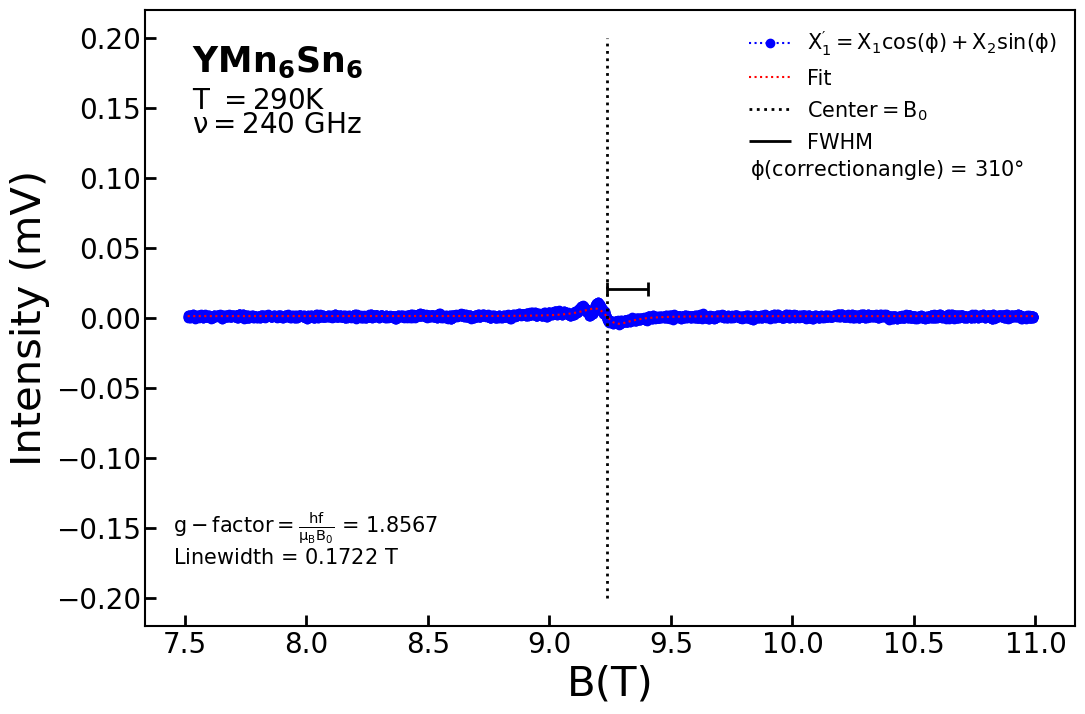

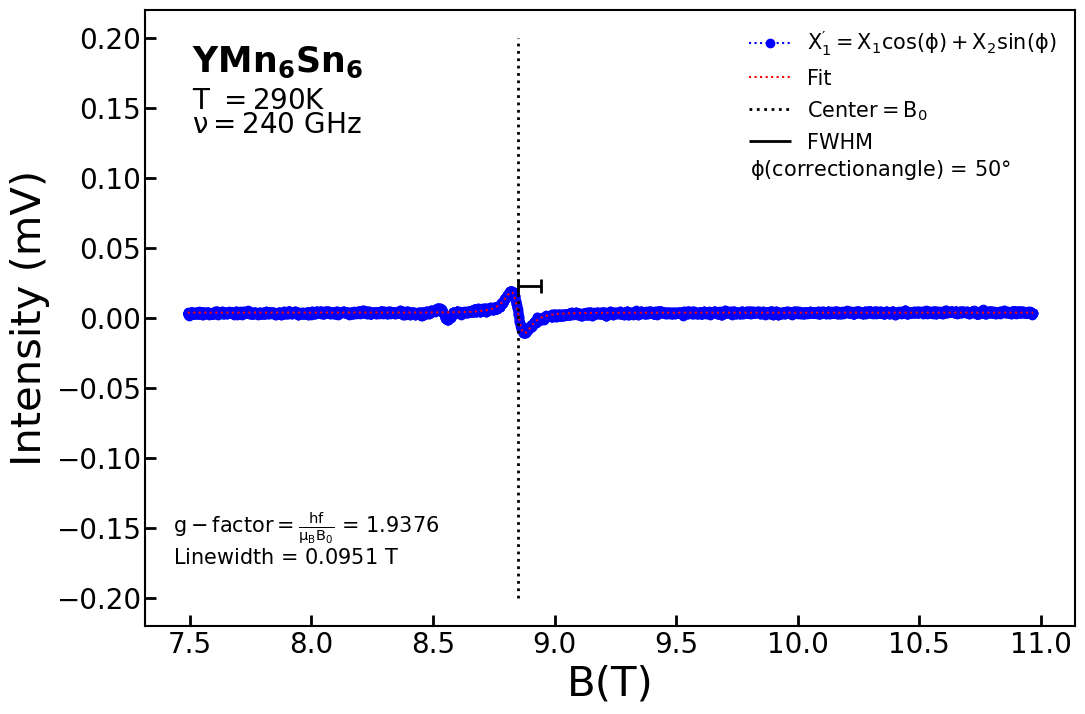

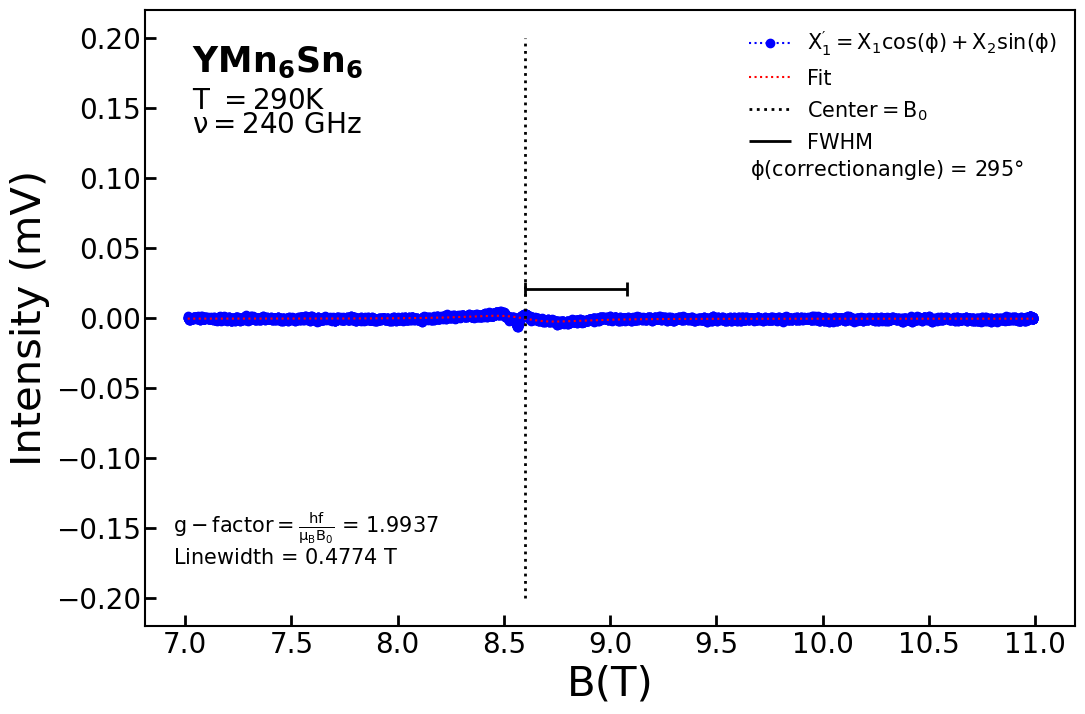

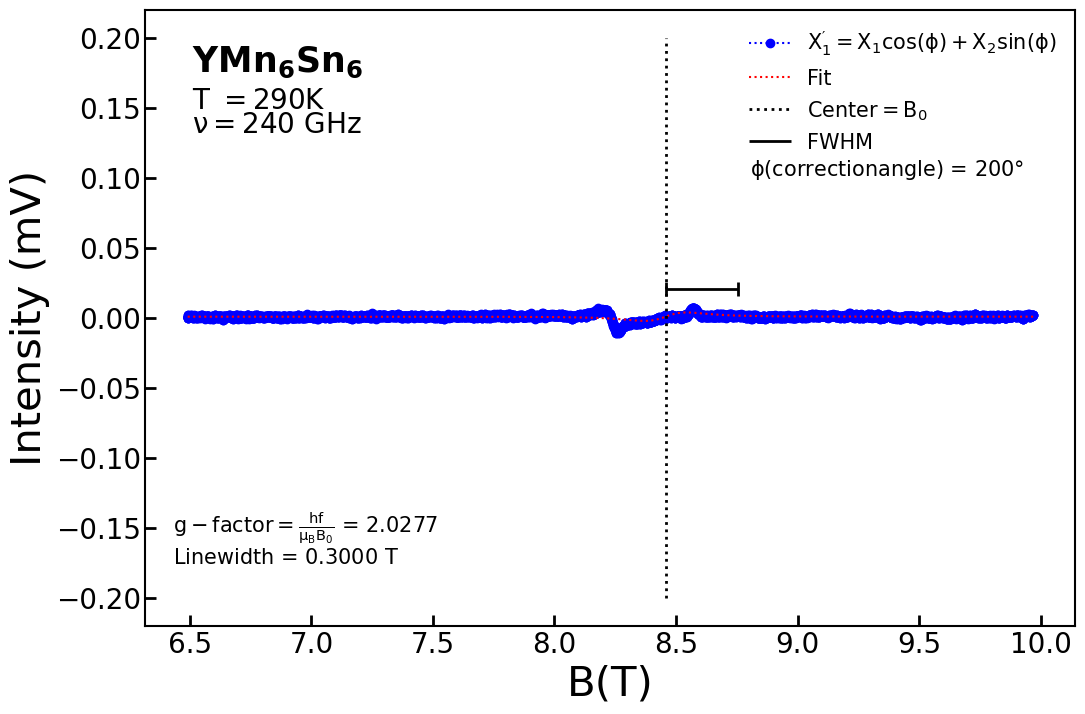

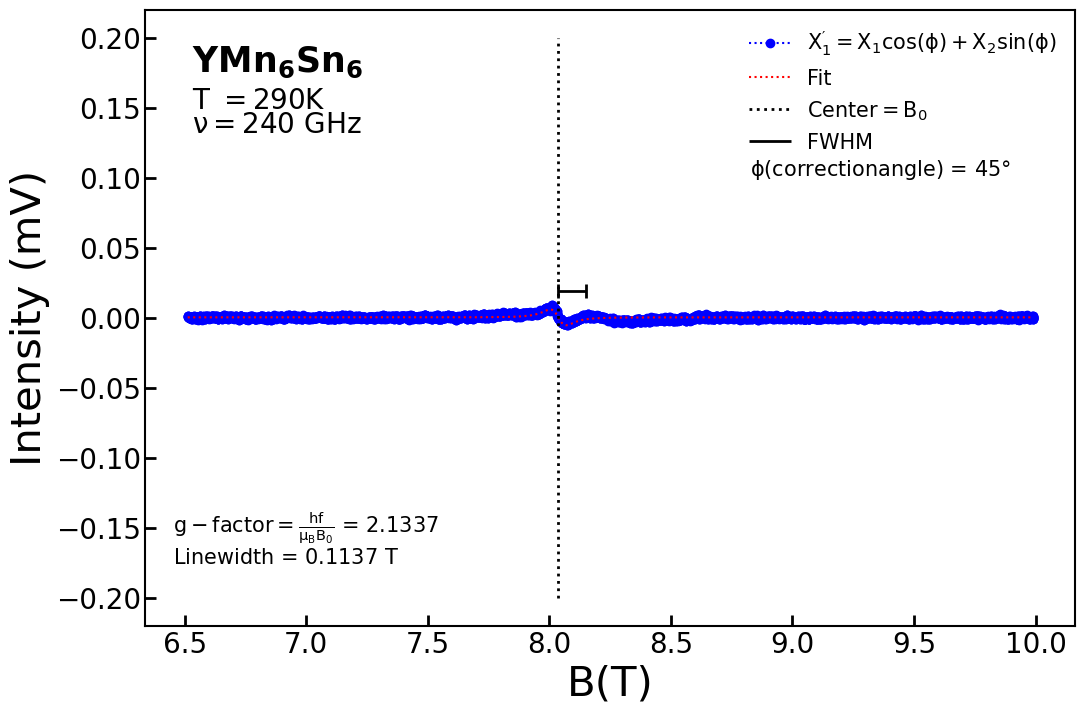

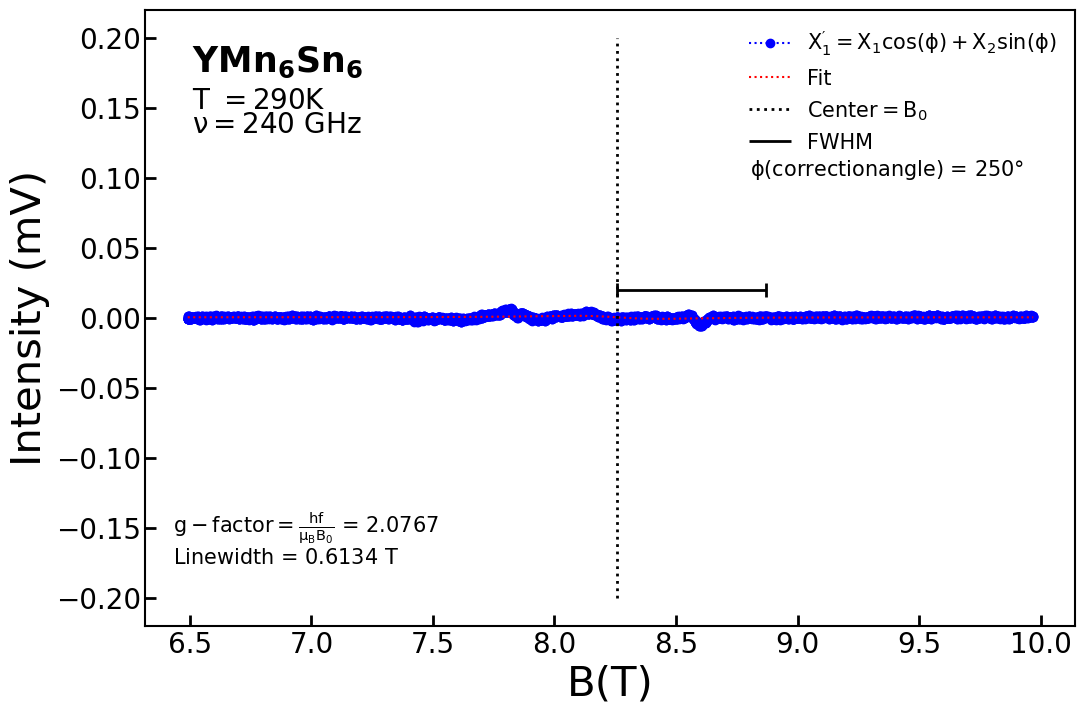

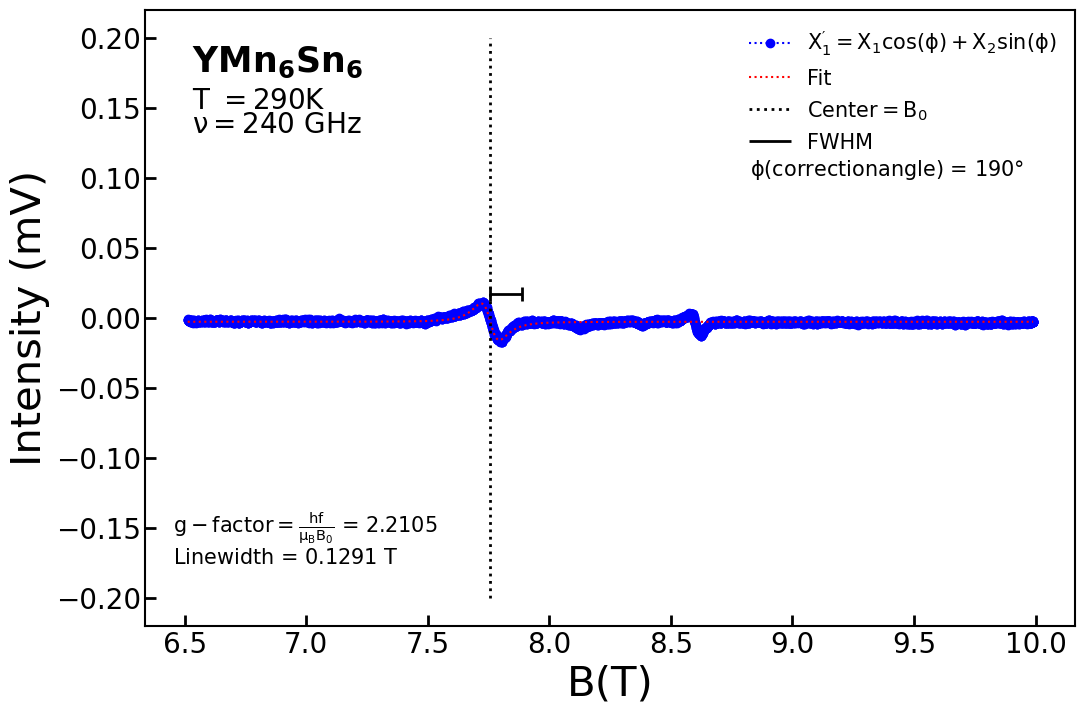

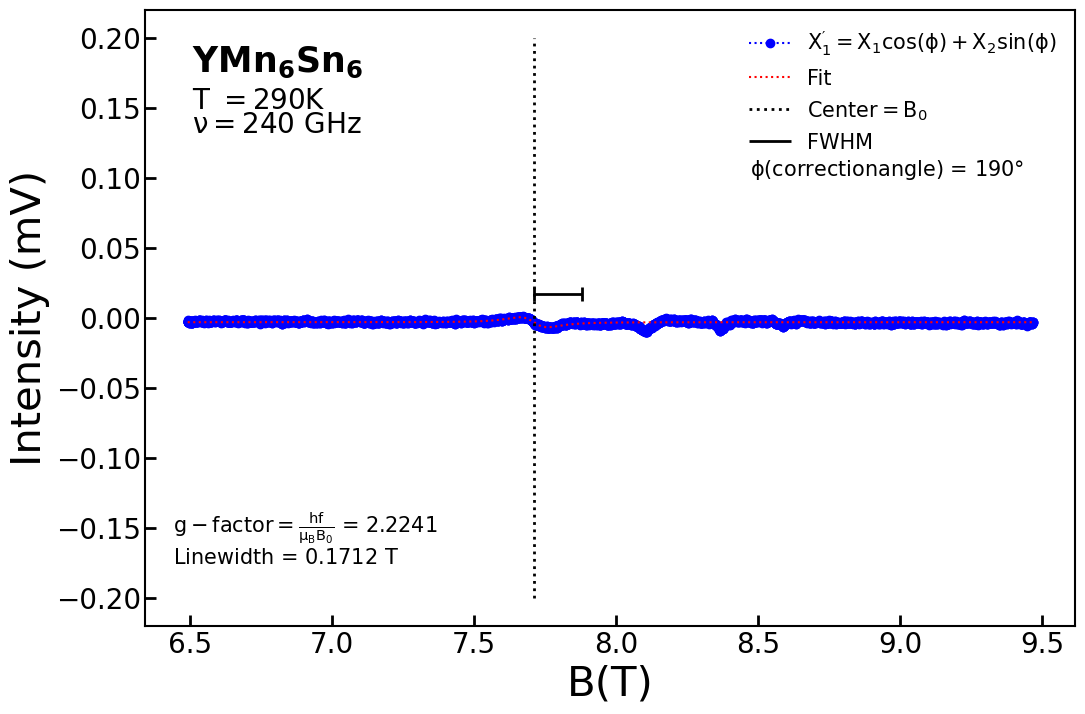

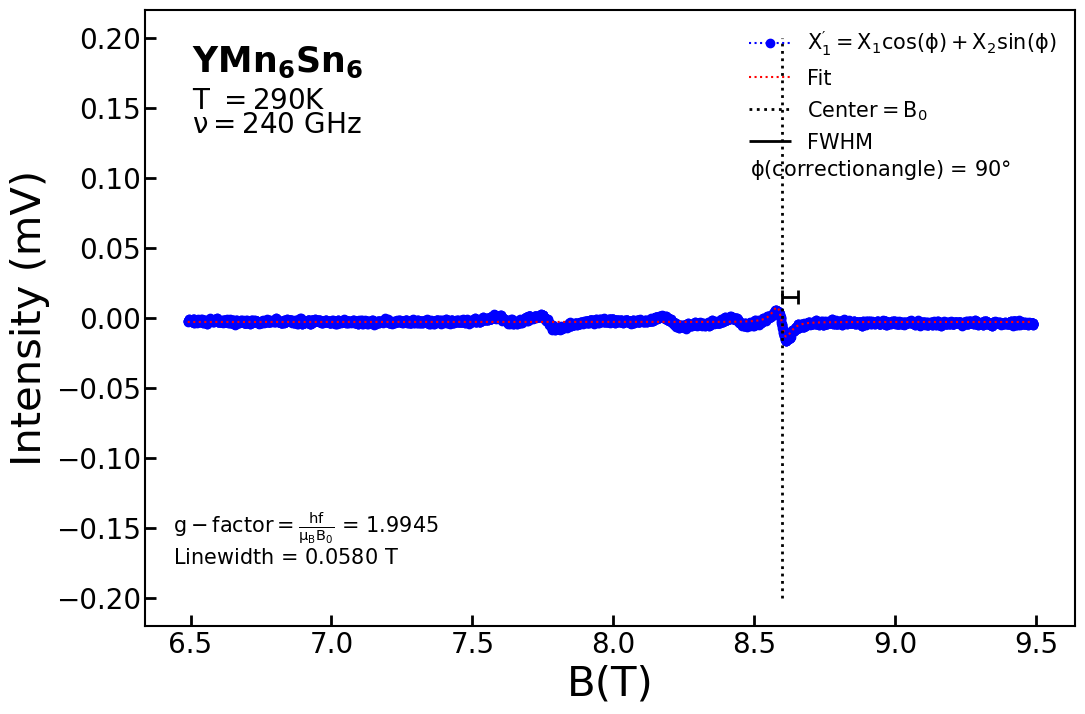

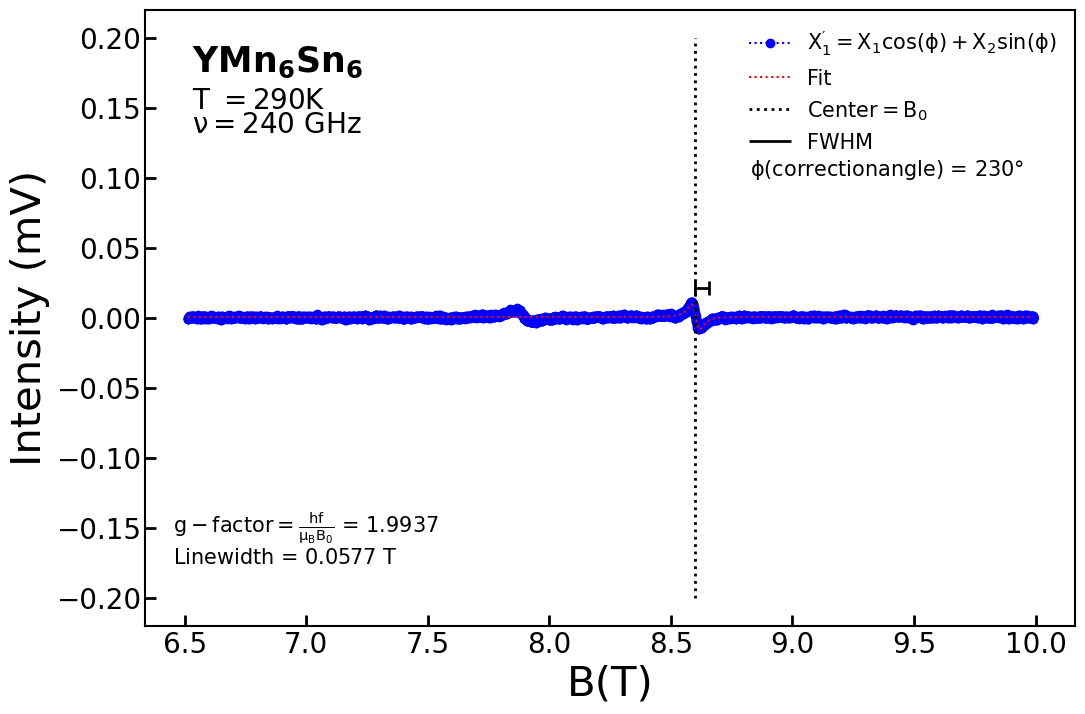

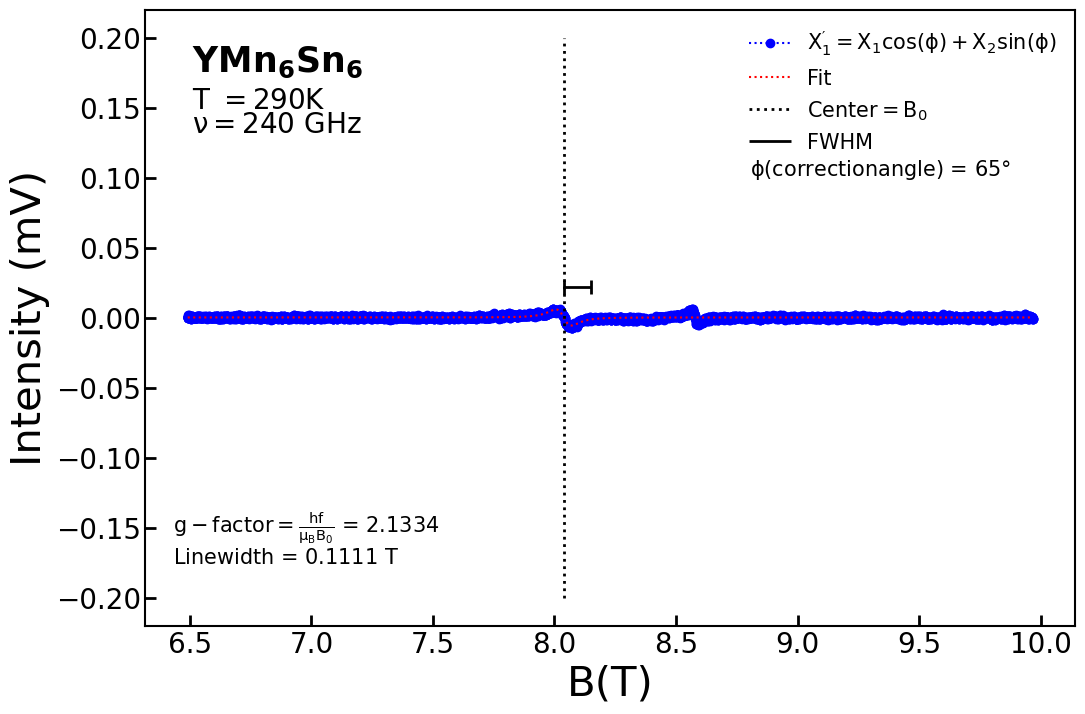

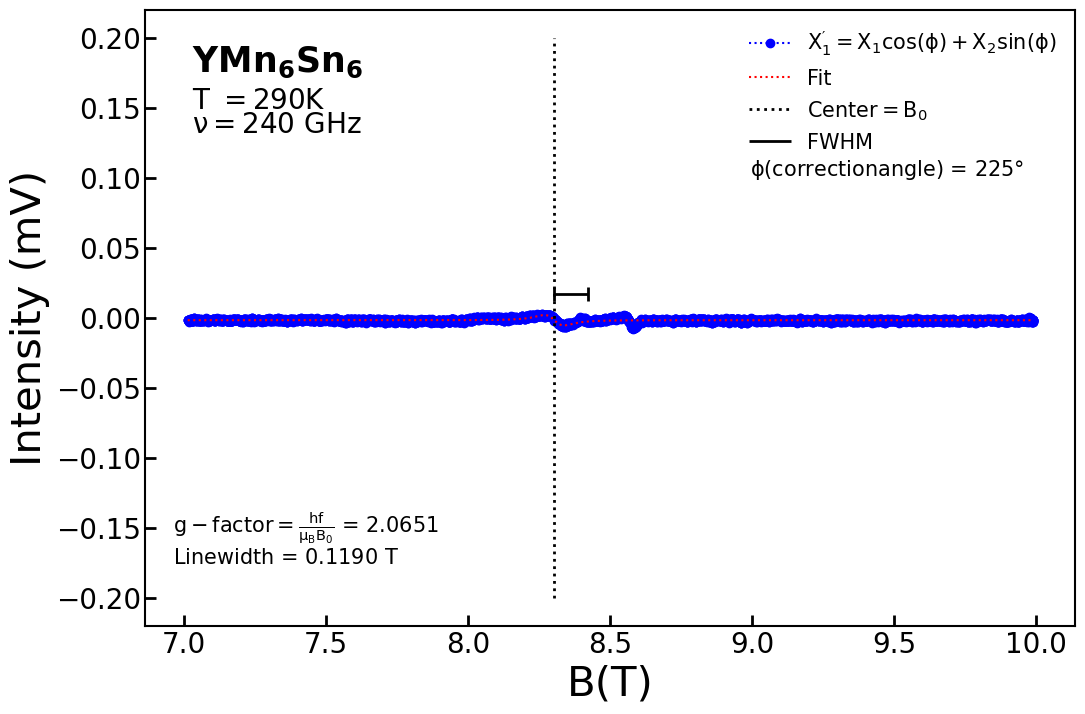

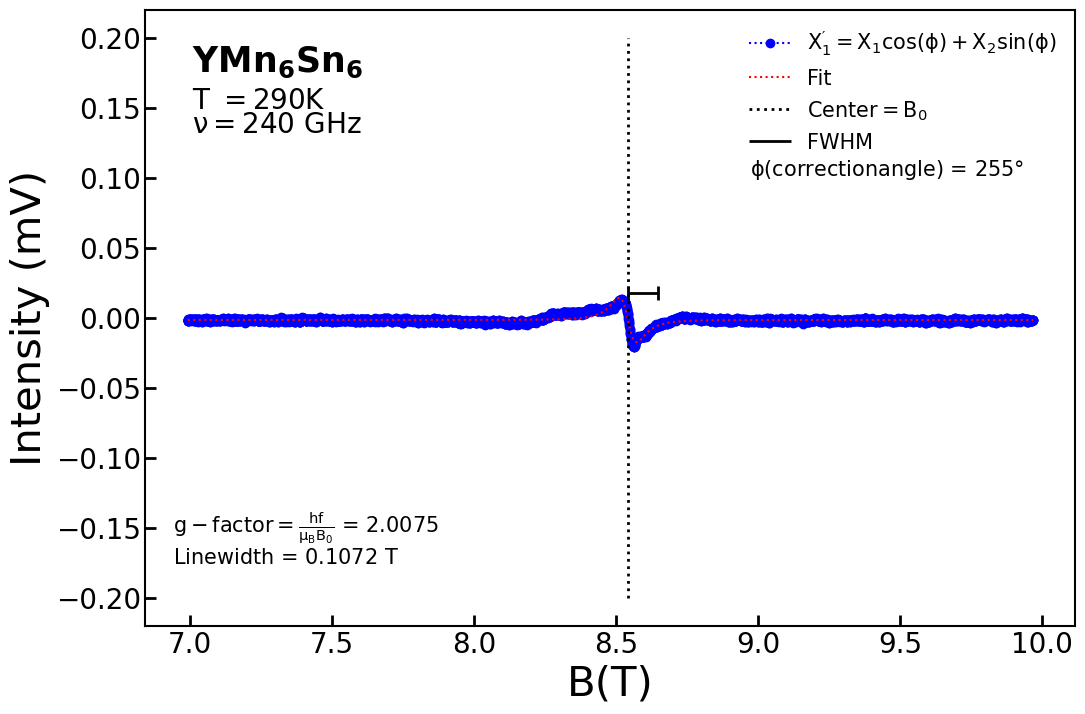

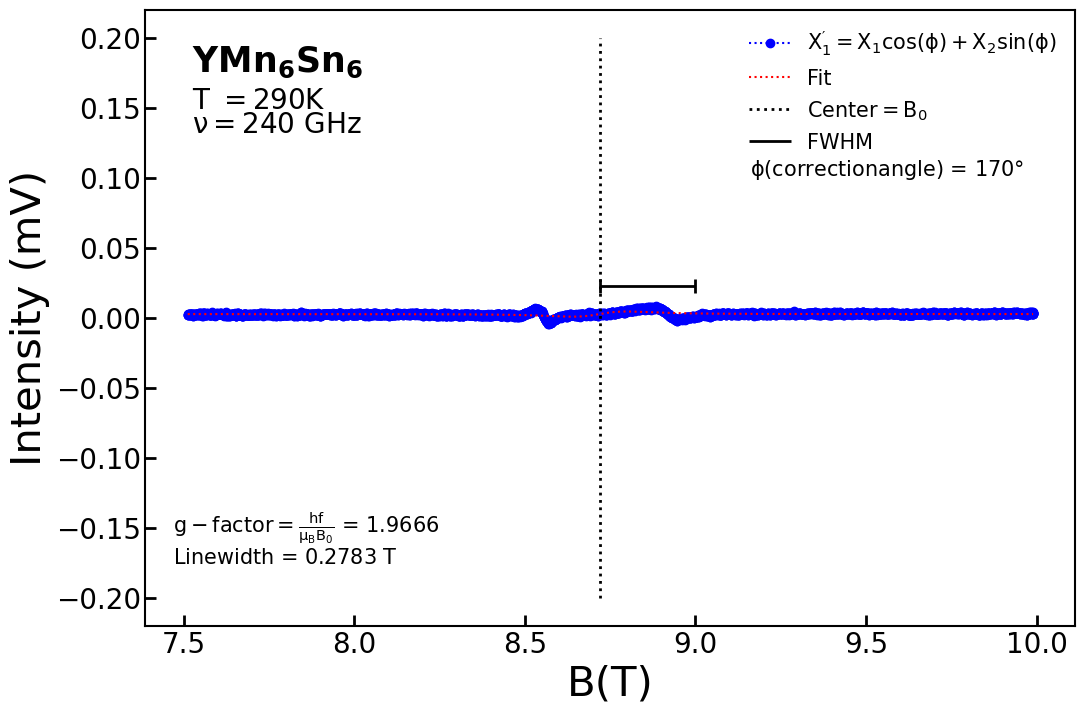

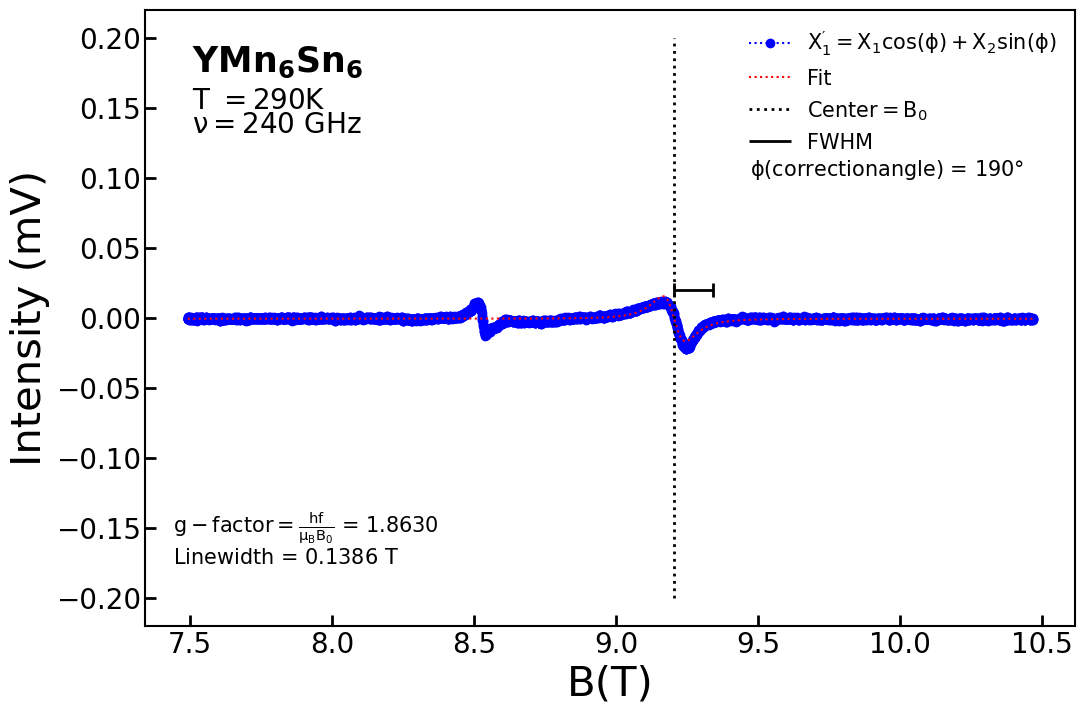

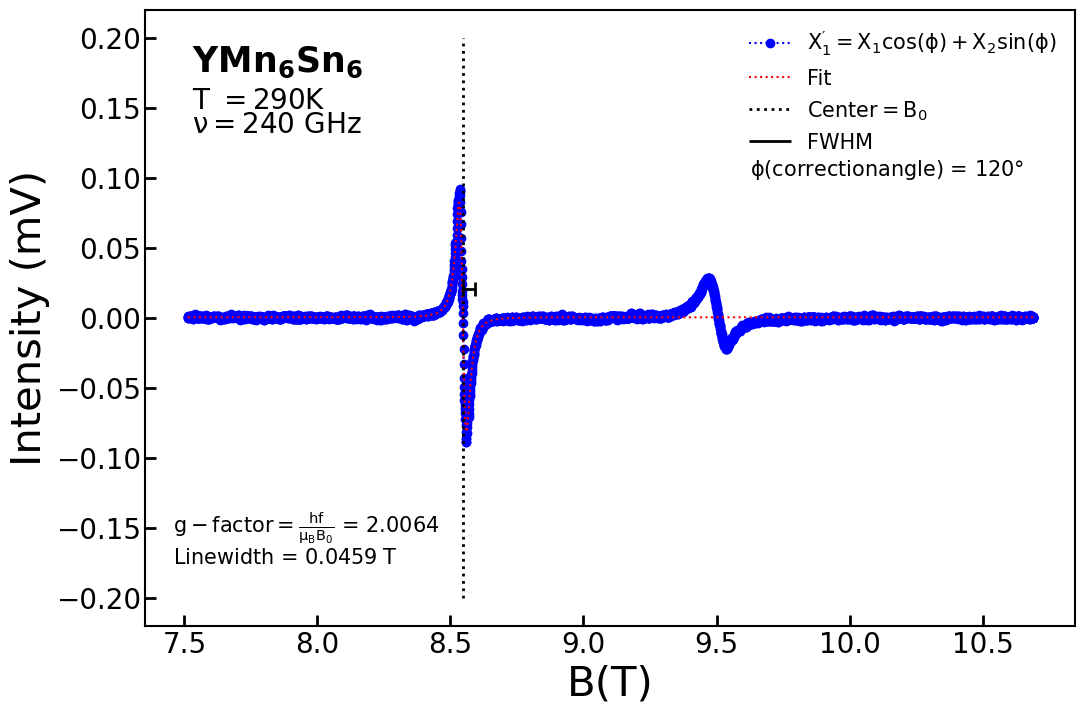

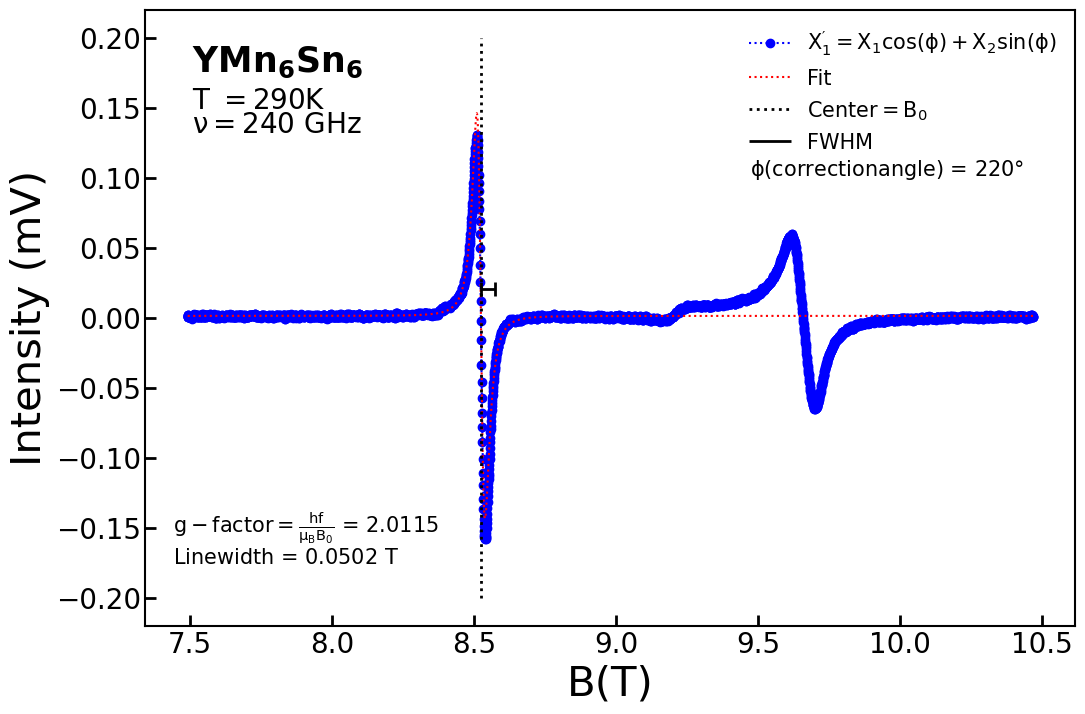

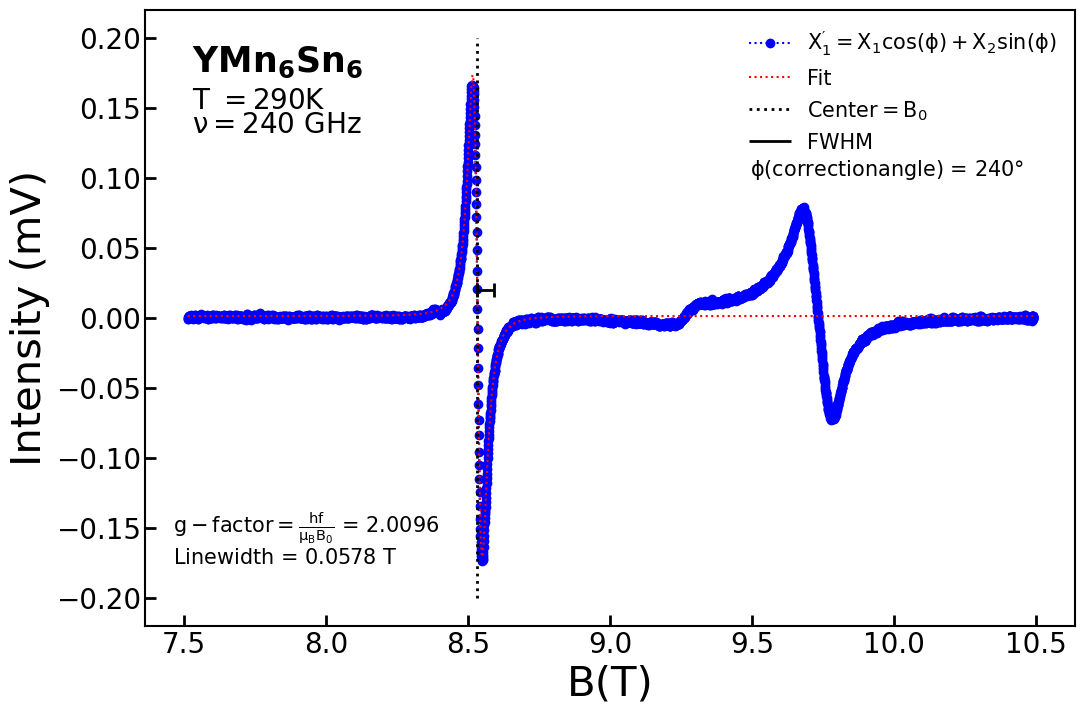

In [94]:
############## Create RAW data Figures For Each Temperature #####################
for i in datafiles:
    fig1,ax=plt.subplots()
    fig1.set_size_inches(12,8)
    fig1.subplots_adjust(hspace=.0)
    fig1.patch.set_facecolor('white')
    
    ax.plot(dict_data[i][0], dict_data[i][4], color="blue", linestyle="dotted", marker='o', label="$X_1'=X_1\cos(\phi)+X_2\sin(\phi)$")
    ax.plot(dict_data[i][5], dict_data[i][6], color="red", linestyle="dotted", label="Fit")

    ax.annotate(r'$YMn_6Sn_6\ $',ha='left', xy=(0.05, 0.9),weight='bold',xycoords='axes fraction', fontsize=25)
    ax.annotate(r'$T\ = $'+str(dict_data[i][3]),ha='left', xy=(0.05, 0.84),xycoords='axes fraction', fontsize=20)
    ax.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=20, color='black')
    

    ax.annotate(r'$\phi (correction angle)$ = '+str(dict_data[i][9])+r'$\degree$',ha='left', xy=(0.65, 0.73),xycoords='axes fraction', fontsize=15)
    ax.annotate(r'$Linewidth$ = '+f"{dict_data[i][8]:.4f} T",ha='left', xy=(0.03,0.10),xycoords='axes fraction', fontsize=15)
    ax.annotate(r'$g-factor = \frac{hf}{\mu_BB_0}$ = '+f"{dict_data[i][7]:.4f}",ha='left', xy=(0.03,0.15),xycoords='axes fraction', fontsize=15)


    
    ax.vlines(x = dict_data[i][10],ymin=-0.2,ymax=0.2, color = 'black',linestyle="dotted",linewidth=2, label = '$Center=B_0$')
    ax.vlines(x = dict_data[i][10],ymin=dict_data[i][11]+0.015,ymax=dict_data[i][11]+0.025, color = 'black',linestyle="solid",linewidth=2)
    ax.vlines(x = dict_data[i][10]+dict_data[i][8],ymin=dict_data[i][11]+0.015,ymax=dict_data[i][11]+0.025, color = 'black',linestyle="solid",linewidth=2)



    ax.hlines(y = dict_data[i][11]+0.02, xmin= dict_data[i][10], xmax=(dict_data[i][10]+dict_data[i][8]), linewidth=2, linestyle="solid", color='black', label='FWHM')




    
    
    ax.legend(loc='upper right', prop={'size': 15}, frameon=False)
    props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
            
    #plt.title(label = r'$\mathrm{CrPS_s\ 240GHz\ EPR}$', fontsize = 32)
    ax.set_xlabel("B(T)", fontsize=30)
    ax.set_ylabel("Intensity (mV)",fontsize=30)
    #ax.set_ylim(-0.2,0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #plt.savefig("YMnS 240GHz Rotational ESR Fits "+i+".png")

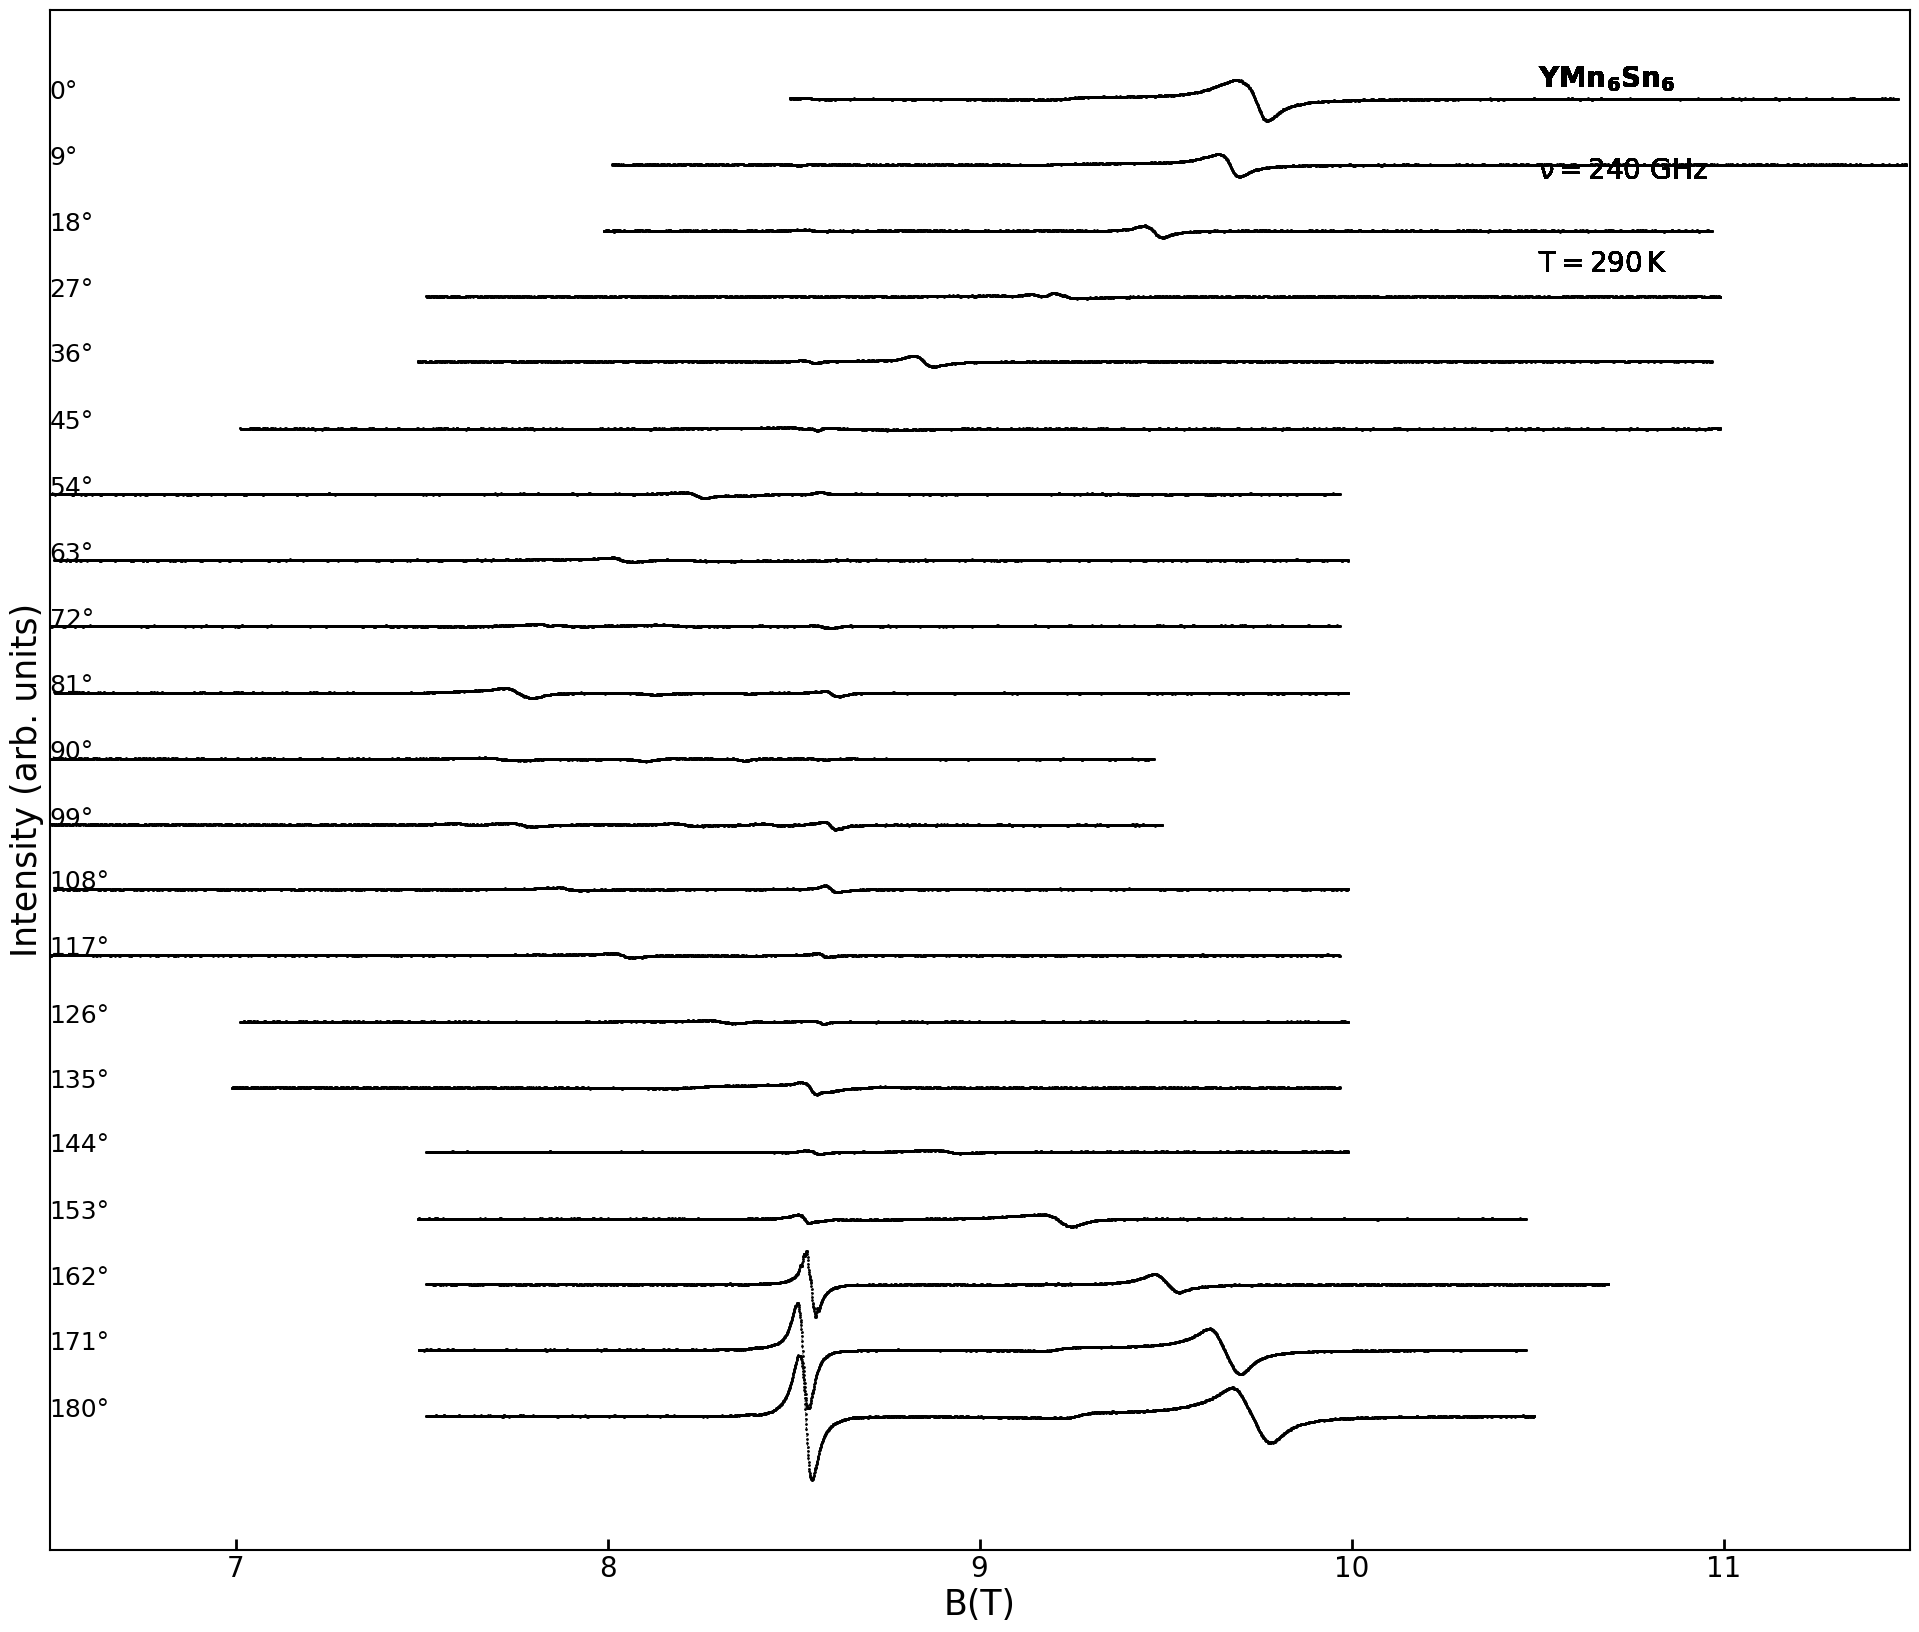

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Your existing code...
# Define temperatures for each dataset
rotations = [0,9,18,27,36,45,54,63,72,81,90]
# Define a custom colormap with grayscale gradient
custom_colors = [(i / (len(rotations) - 1), 'black') for i in range(len(rotations))] # Grayscale gradient
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors)
# Plot data with gradient colors using the custom colormap
fig1, ax = plt.subplots()
fig1.set_size_inches(24, 20)
fig1.patch.set_facecolor('white') # White background
spacing = 0.18 # Adjust spacing between plots
for i, rotation in enumerate(rotations):
    ax.plot(dict_data[datafiles[i]][0], dict_data[datafiles[i]][4] - 0.05 - spacing * i, color=custom_cmap(i / len(rotations)), linestyle="dotted", marker='o', markersize=1, linewidth=0.8)
    ax.annotate(f'{rotation}°', ha='left', xy=(6.5, dict_data[datafiles[i]][4][0] - 0.05 - spacing * i), xycoords='data', fontsize=18, color='black')
    ax.annotate(r'$YMn_6Sn_6$', ha='left', xy=(0.8, 0.95), weight='bold', xycoords='axes fraction', fontsize=20, color='black')
    ax.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.8, 0.89), xycoords='axes fraction', fontsize=20, color='black')
    ax.annotate(r'$T = 290 \, K$', xy=(0.8, 0.85), xycoords='axes fraction', xytext=(0.8, 0.83),ha='left', color='black', fontsize=20)
    ax.set_facecolor('white') # White background
    props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
    ax.set_xlabel("B(T)", fontsize=25, color='black')
    ax.set_ylabel("Intensity (arb. units)", fontsize=25, color='black')
    ax.set_xlim(6.5, 11.5)
    ax.tick_params(axis='both', which='major', labelsize=20, colors='black')
# Remove y-axis ticks and labels
ax.set_yticks([]) # This removes the y-axis ticks and labels
#plt.savefig("YMnSn 240GHz Rotational Waterfall Plot.png", facecolor='white', bbox_inches='tight')
plt.show()

In [96]:
import numpy as np
import pandas as pd
import random
import scipy.constants as scpc
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

resonance_fields = {}

# Define function to extract normal resonance fields
def find_resonance_fields(data):
    B_field = data[0]  # Magnetic field values
    X1_corrected = data[4]  # Corrected intensity

    # Find the most prominent peak (resonance field)
    peak_indices, _ = find_peaks(X1_corrected)
    
    if len(peak_indices) == 0:
        raise ValueError("No peaks found in data")

    peak_idx = peak_indices[np.argmax(X1_corrected[peak_indices])]  # Peak with highest intensity
    return B_field[peak_idx]

# Define function to extract right-side resonance fields
def find_right_resonance(data):
    B_field = data[0]  
    X1_corrected = data[4]

    peak_indices, _ = find_peaks(X1_corrected)
    
    if len(peak_indices) == 0:
        raise ValueError("No peaks found in data")

    # Take the rightmost peak
    peak_idx = peak_indices[-1]  
    return B_field[peak_idx]

# Iterate through all datasets
for i, file_name in enumerate(datafiles):
    try:
        if file_name in [
            "YMnSn_240_290K_500_nextDay",
            "YMnSn_240_290K_450_nextDay",
            "YMnSn_240_290K_400_nextDayFiltered_rephased",
            "YMnSn_240_290K_350_nextDay"
        ]:
            resonance_field = find_right_resonance(dict_data[file_name])
        else:
            resonance_field = find_resonance_fields(dict_data[file_name])

        resonance_fields[rotations[i]] = resonance_field  # Store resonance field with corresponding angle

    except Exception as e:
        print(f"Error processing {file_name} at {rotations[i]} degrees: {e}")

# Check if all 32 datasets have resonance fields
missing_angles = set(rotations) - set(resonance_fields.keys())
if missing_angles:
    print("Missing resonance fields for angles:", missing_angles)
else:
    print("All 21 datasets have been successfully processed!")

print(resonance_fields)


All 21 datasets have been successfully processed!
{0: 9.682347316881001, 9: 9.642017145777263, 18: 9.444195623460924, 27: 9.202285819948257, 36: 8.823755518280622, 45: 8.483945358092457, 54: 8.56858356465433, 63: 8.012201841731764, 72: 7.819712294248432, 81: 7.727209241187028, 90: 7.670889984825133, 99: 8.575219440066512, 108: 8.587511639530215, 117: 8.022241804907164, 126: 8.24388824837261, 135: 8.51731631312792, 144: 8.88484905675742, 153: 10.466074760725174, 162: 7.514266023177658, 171: 10.465984718102357, 180: 7.517768495435431}


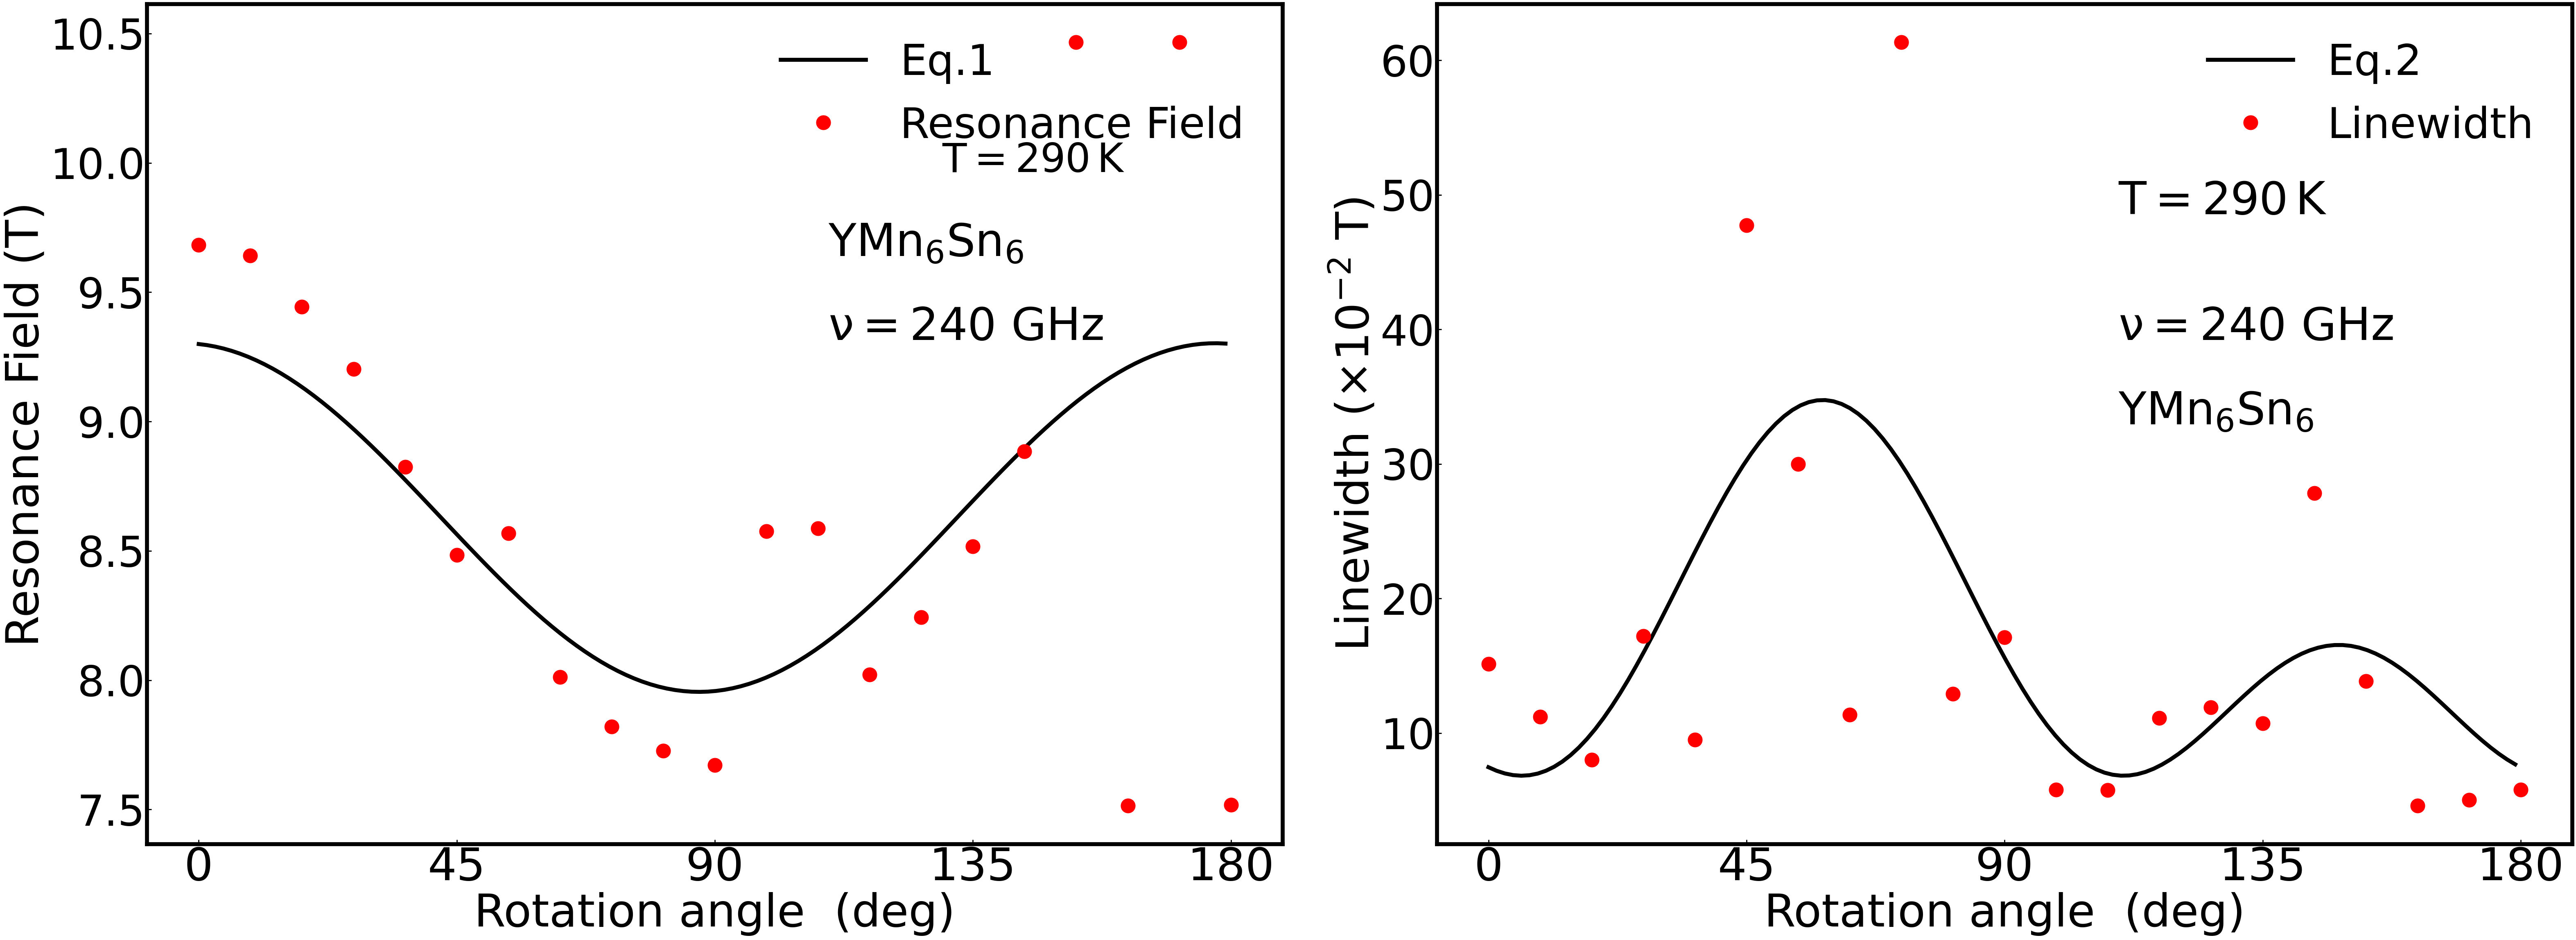

In [138]:
def W(x, A,B,s,C):
    w = (A*(np.cos(x-s)**2+1)+B*(np.cos(x-s)**4)+C)
    return w
              
Wparameters,_=curve_fit(W,rotations_radians,linewidths)
x_line_w = np.arange(min(rotations_radians),max(rotations_radians),0.025)
dy_line_w = W(x_line_w, Wparameters[0],Wparameters[1],Wparameters[2],Wparameters[3])

def U(x, A,B,s):
    u = (A*(np.cos(x-s)**2-1)+B)
    return u
              
resonance_values = np.array(list(resonance_fields.values()), dtype=float)

rotations_degrees = np.arange(0, 180, 9)


Uparameters,_=curve_fit(U, rotations_radians, resonance_values)
x_line_u = np.arange(min(rotations_radians),max(rotations_radians),0.025)
dy_line_u = U(x_line_u, Uparameters[0],Uparameters[1],Uparameters[2])

tick_labels = ['0', '45', '90', '135', '180']


# Generate tick locations corresponding to the 8 labels
tick_locations = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]

fig1, ((ax1, ax2)) = plt.subplots(1, 2)
fig1.subplots_adjust(hspace=.0)
fig1.patch.set_facecolor('white')
fig1.set_size_inches(65,25)

# Plot for g-factors
#x_indices = np.arange(len(rotations_radians))  # evenly spaced indices
ax1.set_xlabel(r'Rotation angle  (deg)', fontsize=80)
ax1.set_ylabel(r'Resonance Field (T)', fontsize=80)
ax1.plot(x_line_u, dy_line_u, color='black', linewidth=7, label="Eq.1")
resonance_values = [resonance_fields[angle] for angle in rotations if angle in resonance_fields]
ax1.plot(rotations_radians, resonance_values, color='red', marker="o", markersize=25,markerfacecolor='Red', linestyle='None', label="Resonance Field", linewidth=6)
ax1.legend(frameon=False, loc='upper right')
ax1.annotate(r'$YMn_6Sn_6$', ha='left', xy=(0.6, 0.7), xycoords='axes fraction', fontsize=80, color='black')
ax1.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.6, 0.6), xycoords='axes fraction', fontsize=80, color='black')
ax1.annotate(r'$T = 290 \, K$', xy=(0.45, 0.5), xycoords='axes fraction', xytext=(0.7, 0.8),ha='left', color='black', fontsize=70)

# Plot for Linewidth
ax2.set_xlabel(r'Rotation angle  (deg)', fontsize=80)
ax2.set_ylabel(r'Linewidth ($\times 10^{-2}$ T)', fontsize=80)
ax2.plot(x_line_w, np.array(dy_line_w) * 10**2, color='black', linewidth=7,  label="Eq.2")
ax2.plot(rotations_radians, np.array(linewidths) * 10**2, color='red', marker="o", markersize=25,markerfacecolor='Red', linestyle='None', label="Linewidth", linewidth=6)
ax2.legend(frameon=False, loc='upper right')
ax2.annotate(r'$YMn_6Sn_6$', ha='left', xy=(0.6, 0.5), xycoords='axes fraction', fontsize=80, color='black')
ax2.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.6, 0.6), xycoords='axes fraction', fontsize=80, color='black')
ax2.annotate(r'$T = 290 \, K$', xy=(0.4, 0.5), xycoords='axes fraction', xytext=(0.6, 0.75),ha='left', color='black', fontsize=80)

# Set ticks and labels for ax1
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(tick_labels, fontsize=80)

# Set ticks and labels for ax2
ax2.set_xticks(tick_locations)
ax2.set_xticklabels(tick_labels, fontsize=80)

# Increase axis line thickness
ax1.spines['bottom'].set_linewidth(7)  
ax1.spines['left'].set_linewidth(7)    
ax1.spines['top'].set_linewidth(7)     
ax1.spines['right'].set_linewidth(7)   

# Increase axis line thickness
ax2.spines['bottom'].set_linewidth(7)  
ax2.spines['left'].set_linewidth(7)    
ax2.spines['top'].set_linewidth(7)     
ax2.spines['right'].set_linewidth(7)

plt.tight_layout()
plt.savefig("YMnSn 240 Rotation Resonance Parameter Plots.png")
plt.show()
